In [1]:
import pandas as pd
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.pipeline import make_pipeline

from aif360.sklearn.preprocessing import ReweighingMeta, Reweighing
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

from sklego.preprocessing import InformationFilter

from fairness import fairestimator
from fairness.blog import utils

np.random.seed(42)

# Ignoring bias for classification problems

This notebook is part of a blog series where I investigate bias in AI.

1. [Introducing the IgnoringEstimator](https://github.com/SjoerdCor/fairness/blob/main/blog/1.IntroducingTheIgnoringEstimator.ipynb) introduced measures of fairness and showed how naive approaches do not solve them, and on the other hand shows how easily the IgnoringEstimator is implemented and solves them well
1. [Dealing with more complex biases](https://github.com/SjoerdCor/fairness/blob/main/blog/2.DealingWithMoreComplexBiases.ipynb) showed how common complex biases are: non-linear, correlated with other attributes and for continuous features, and showed how easy it is to mitigate the disparate treatment with the `IgnoringBiasEstimator`. I also showed how little attention there seems to be for this problem in existing approaches.
1. [Ignoring bias for cassification poblems](https://github.com/SjoerdCor/fairness/blob/main/blog/3.IgnoringBiasForClassificationProblems.ipynb) finally shows how to use the Ignoring Estimator for the classic classification problems - since these are more prolific, we can also compare against a wide variety of existing approaches and see the `IgnoringBiasEstimator` does equally well or better both in terms of bias mitigation and accuracy.



In this imnstallment, I will use the IgnoringBiasClassifier, which eliminates Disparate Treatment for classification problems. Additionally, I will apply a wide variety of other bias mitigation strategies to make a comprehensive comparison, and show that the IgnoringBias does equally well or better both in terms of bias mitigation and accuracy.

## Creating the dataset
For the last time in this blog, we stick to the employee situation. Image the company now sets out to predict who should be promoted, based on skills. This should only depend on SocialSkills and Education, but in the real world also depends quadratically on age.

<img src="./figures/DGP_classification.PNG" title="The data generating process for salary for an imaginary company with biases in employee salaries"/>

In [2]:
def generate_employees_age(size=2500):
    X = (pd.DataFrame({'Age': 25 + 40 * np.random.rand(size),
                       'Education': 4 + 16 * np.random.rand(size),
                       'SocialSkills': np.random.rand(size)
                      }
                     )
        )
    return X

def eligibility_to_promotion(e):
    ''' Real numer -> 0/1 based on binomial distribution via sigmoid'''
    prob = scipy.special.expit(e)  # Use logistic function to map real number to probability in range [0, 1]
    return np.random.binomial(1, prob) # Turn into yes/no

def add_promotion(df):
    weights = {'Age': 0,
               'Education': 0.02,
               'SocialSkills': 0.1
              }
    error = np.random.normal(-2, 0.2, size=len(df))
    df = df.assign(PromotionEligibilitySkill = lambda df: df.mul(weights).sum('columns').add(error),
                   PromotionEligibilityTrue = lambda df: (df['PromotionEligibilitySkill']
                                                          .add(utils.generate_bias(df['Age'], effect_size=-0.4, power=2))
                                                         ),
                   PromotionSkill = lambda df: df['PromotionEligibilitySkill'].apply(eligibility_to_promotion),
                   PromotionTrue = lambda df: df['PromotionEligibilityTrue'].apply(eligibility_to_promotion),
                  )
    return df

df = generate_employees_age(25000).pipe(add_promotion)
PROTECTED_ATTRIBUTE = ['Age']

In [3]:
utils.display_df(df)

,Age,Education,SocialSkills,PromotionEligibilitySkill,PromotionEligibilityTrue,PromotionSkill,PromotionTrue
6868,48.12,5.41,0.01,-1.93,-1.52,1,0
24016,32.33,16.42,0.32,-1.92,-2.02,1,0
9668,53.25,13.57,0.90,-1.85,-1.63,0,0
13640,45.51,7.79,0.61,-1.65,-1.21,0,0
14018,63.62,15.83,0.75,-1.20,-1.91,0,1
7488,48.97,5.16,0.47,-1.80,-1.41,0,1
5804,40.13,18.94,0.21,-1.52,-1.16,0,1
12909,60.60,7.33,0.46,-1.92,-2.28,0,0
3386,34.74,15.03,0.97,-1.70,-1.61,0,0
9567,60.64,14.87,0.99,-1.32,-1.69,1,0


In [4]:
(X_train, X_test,
 y_train, y_test,
 y_skill_train, y_skill_test,
 promotion_prob_skill_train, promotion_prob_skill_test) = sklearn.model_selection.train_test_split(df.filter(['Age', 'Education', 'SocialSkills', 'Experience']),
                                                                                                   df['PromotionTrue'],
                                                                                                   df['PromotionSkill'],
                                                                                                   df['PromotionEligibilitySkill'],
                                                                                                   random_state=42
                                                                                                    )

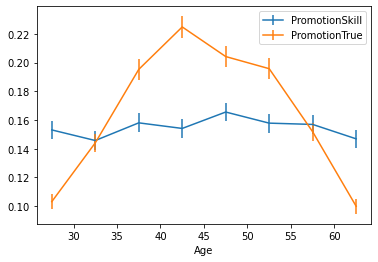

In [5]:
def plot_promotion_prob_by_age(predictions, age, age_group=5, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    age_grouped = age // age_group * age_group + age_group/2
    result = predictions.groupby(age_grouped).agg(['mean', 'sem'])
    ax = (result.plot(y='mean', yerr='sem', ax=ax, label=predictions.name, **kwargs))
    return ax
    
ax = plot_promotion_prob_by_age(df['PromotionSkill'], df['Age'])
plot_promotion_prob_by_age(df['PromotionTrue'], df['Age'], ax=ax)
plt.show()

Indeed, the promotions based on skills are independent of age, but in the real world middle-aged people have much higher probability of a promotion

## Calculating the predictions
We apply a variety of bias mitigation strategies that work with continuos features:
* No bias mitigation strategy, as a baseline
* Preprocessing: InformationFilter, as implemented by `scikit-lego`
* Preprocessing: Reweighing, as implemented by `aif360`
* Inprocessing: AdversarialDebiasing, as implemented by `aif360`
* Postprocessing: CalibratedOddsEqualizer, as implemented by `aif360`
* Inprocessing: IgnoringBiasClassifier, as defined within this repository



In [6]:
predictions = {}

In [7]:
def add_predictions_to_results(clf, name, predictions=predictions,
                               X_train=X_train, y_train=y_train, X_test=X_test,
                               protected_attribute=None):
    """
    
    """
    
    if protected_attribute: 
        X_train = X_train.set_index(protected_attribute, append=True)
        X_test = X_test.set_index(protected_attribute, append=True)
        
    clf.fit(X_train, y_train)
    y_pred = utils.predict_series(clf, X=X_test, method='predict_proba')
    
    if protected_attribute:
        y_pred = y_pred.reset_index(protected_attribute, drop=True)
    predictions[name] = y_pred

In [8]:
rf_kwargs = {'min_samples_leaf': 2, 'random_state': 42}

### No bias mitigation
As a baseline, let's first calculate the naive approach of fitting a model with the protected attribute as a feature, applying no bias mitigation

In [9]:
rf = RandomForestClassifier(**rf_kwargs)
add_predictions_to_results(rf, 'NoBiasMitigation')

### scikit-lego preprocessing: Information Filter
Secondly, let's apply the Information Filter

In [10]:
clf_information_filter = make_pipeline(InformationFilter(PROTECTED_ATTRIBUTE),
                                       RandomForestClassifier(**rf_kwargs),
                                      )
add_predictions_to_results(clf_information_filter, 'InformationFilter')

### aif360 Preprocessing: reweighing

In [11]:
%%time
clf_reweighing = ReweighingMeta(RandomForestClassifier(**rf_kwargs), reweigher=Reweighing(PROTECTED_ATTRIBUTE))
add_predictions_to_results(clf_reweighing, 'Reweighing', protected_attribute=PROTECTED_ATTRIBUTE)

Wall time: 41.3 s


### aif360 Inprocessing: Adversarial Debiasing

In [ ]:
%%time
clf_adv_deb = AdversarialDebiasing(prot_attr=PROTECTED_ATTRIBUTE, adversary_loss_weight=None, random_state=42, classifier_num_hidden_units=64)
add_predictions_to_results(clf_adv_deb, 'AdversarialDebiasing', protected_attribute=PROTECTED_ATTRIBUTE)

### aif360 Postprocessing: CalibratedOddsEqualizer

In [ ]:
def add_age_index(series, age_series, dummify=None):
    '''
    dummify: tuple of low and high to dummify; None if you do not want to dummify
    ''' 
    
    res = pd.concat([series, age_series], axis='columns')
    if dummify:
        res['Age'] = res['Age'].between(*dummify).astype(int)
    res = res.set_index('Age', append=True).squeeze()
    return res

In [ ]:
advantaged_age_group = (32.5, 57.5)
y_train_with_age = add_age_index(y_train, X_train['Age'], advantaged_age_group)
y_test_with_age = add_age_index(y_test, X_test['Age'], advantaged_age_group)

In [ ]:
clf_postproc = PostProcessingMeta(estimator=RandomForestClassifier(**rf_kwargs),
                                  postprocessor=CalibratedEqualizedOdds(PROTECTED_ATTRIBUTE, random_state=42),
                                  random_state=42)

X_test_grouped_age = X_test.assign(Age = lambda df: df['Age'].between(*advantaged_age_group).astype(int))  # CalibratedOddsEqualizer requires exactly two groups
add_predictions_to_results(clf_postproc, 'CalibratedOddsEqualizer', y_train=y_train_with_age, protected_attribute=PROTECTED_ATTRIBUTE, X_test=X_test_grouped_age)

### Ignoring Bias during prediction again solves the problem

In [ ]:
ib = fairestimator.IgnoringBiasClassifier(RandomForestClassifier(random_state=42, min_samples_leaf=2),
                                          ignored_cols=[0], # Ignore the zeroeth column at prediction time -> Age
                                          correction_strategy='Logitadditive')

add_predictions_to_results(ib, 'IgnoringBias')

In [ ]:
df_predictions = pd.DataFrame(predictions)
df_bias = df_predictions.sub(promotion_prob_skill_test, axis=0)

## Evaluating the different options
### Measuring fairness
We have applied six bias mitigation strategies, and now we can finally visualize the results. We are looking for two twhings:
1. The probability of a promotion should be unbiased, i.e. it should equal for every age group (in this toy dataset skills are independent of age). Just as in [Blog 2](https://github.com/SjoerdCor/fairness/blob/main/blog/2.DealingWithMoreComplexBiases.ipynb), we will use the Mutual Information as a fairness measure.
1. The probability of promotion should be well-calibrated, i.e. the average predicted promotion probability should match the average true promotion probability

In the plot, we see three groups:

* The strongly biased strategy, matching the grey dashed line: the true world biased promotion probabilities
  * Applying No Bias Mitigatoin (blue line) propagates the bias
* The largely unbiased, but badly calibrated strategies
  * AdversialDebiasing (red line)does not exhibit a large bias, but gives everybody a way too low probability of promotion. Perhaps we could improve this with more tweaking, but since it is already very slow and other strategies are succesful out of the box, I decided not to spend more time on this
  * Reweighing (green) also is a largely flat line, but also is generally too low
* The (mostly) successful strategies, closely following the black dahsed line: the promotion probabilities based purely on skill.
  * InformationFilter (in orange) is well-calibrated, but does show some bias against older employees
  * Postprocessing with the CalibratedOddsEqualizer (purple) does very well, which is somewhat surprising given that we had to discretize Age. However, I fear it will not scale well to more complex, continuous biases where we do not know well who is (dis)advantaged beforehand.
  * IgnoringBias does very well, both on removing bias and calibration

In [ ]:
ax = plot_promotion_prob_by_age(y_skill_test, X_test['Age'], figsize=(16, 12), ls='--', c='k')
plot_promotion_prob_by_age(y_test, X_test['Age'], ax=ax, ls='--', c='grey')

for col in df_predictions:
    plot_promotion_prob_by_age(df_predictions[col], X_test['Age'], ax=ax)

ax.set_ylabel('')
plt.show()

In [ ]:
%%time 
df_disp_treat = (utils.bootstrap(utils.calculate_mutual_information, pd.concat([df_bias, X_test['Age']], axis='columns'), n_neighbors=100)
                 .pipe(utils.calculate_bootstrap_confidence_interval)
                )

Finally, we calculate the disparate treatment as the mutual information between the age and the bias , which is the difference between the predicted probability of promtion and the skills-based probability of promotion. Indeed, 4 strategies are (mostly) sucessful in removing the bias, the Information Filter is slgihtly less sucessfull and the IgnoringBiasEstimator, again, has the best performance, both in terms of accuracy and bias mitigation, and arguably in ease-of-use.

In [ ]:
def plot_biases(biases: dict, **kwargs):
    """
    Plot fairness metric with uncertainty for multiple mitigation strategies.

    biases: fairness metrics, dict of dicts structured 
        {"name": {"diff_mean": fairness metric, "diff_sem": uncertainty fairness metric}}
    **kwargs are passed to the DataFrame plot method
    """
    fig, ax = plt.subplots()
    df = pd.DataFrame(biases).transpose()
    p = ax.barh(y=range(len(df)), width=df[0.5], xerr=(df['Uncertainty_lower'], df['Uncertainty_upper']))
    plt.yticks(range(len(df)), df.index)
    ax.invert_yaxis()
    ax.axvline(0, c='k', ls='--')
    ax.bar_label(p, label_type='edge', fmt='%.3f')

    ax.set_ylabel('FairnessMethod')
    return ax

plot_biases(df_disp_treat)

### Measuring accuracy
As a measure of the accuracy of the methods, we use [log loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html), which checks both calibration and accuracy.

Importantly, IgnoringBiasEstimator has both the best accuracy and the least disparate treatment. Additionally, it is clear that AdversarialDebiasing does poorly, due to its horrible calibration. 

In [ ]:
accs = df_predictions.apply(lambda col: sklearn.metrics.log_loss(y_test, col))

In [ ]:
ax = accs.plot(kind='barh')
plt.bar_label(ax.containers[0], fmt='%.3f', c='white', label_type='center')
ax.invert_yaxis()
plt.ylabel('Bias mitigation strategy')
plt.xlabel('Logloss (lower is better)')
plt.show()

## Conclusion

In this installment, we saw that for classification problems a wide variety of bias mitigation strategies exist, and that the IgnoringBiasClassifier was best in class both in terms of bias mitigation and accuracy. 

I truly hope the IgnoringBiasEstimator will help mitigate biases in Data Science.